In [1]:
## Import packages
import pandas as pd
import numpy as np
import plotly
from sqlalchemy import create_engine
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import lxml

In [2]:
engine = create_engine('sqlite:///%s' % '../data/coviddb')
df = pd.read_sql_table('CovidData', engine)

In [3]:
df.shape

(497, 34)

In [4]:
df.head()

,CityName,county_fips,state_id,density,ACCESS2,ARTHRITIS,BINGE,BPHIGH,BPMED,CANCER,...,MAMMOUSE,MHLTH,OBESITY,PAPTEST,PHLTH,SLEEP,STROKE,TEETHLOST,case1m,death1m
0,Abilene,48441,TX,441.0,22.60,24.30,17.60,31.10,68.00,5.90,...,73.45,13.20,35.10,77.80,13.30,33.55,3.25,15.65,2648.300808,40.370439
1,Akron,39153,OH,1233.0,12.40,28.95,15.45,36.40,71.70,6.05,...,73.10,15.55,36.10,79.55,15.15,43.15,4.15,21.55,1709.592780,207.080750
2,Alameda,6001,CA,2927.0,7.50,17.90,17.85,24.80,63.00,5.85,...,77.90,9.75,18.30,80.60,9.05,33.70,2.20,7.50,2110.346137,62.869091
3,Berkeley,6001,CA,4509.0,7.40,16.55,19.20,22.70,61.00,5.45,...,79.85,10.50,19.55,82.25,8.60,32.35,2.10,6.75,2110.346137,62.869091
4,Fremont,6001,CA,1171.0,7.65,15.15,16.75,22.85,61.85,5.00,...,77.80,8.45,15.50,79.15,7.75,34.30,1.75,6.75,2110.346137,62.869091


In [5]:
cm = df.corr()[['death1m']][2:-2]

In [6]:
import plotly.express as px
fig = px.bar(x=cm.index, y=cm)
fig.update_layout(xaxis_tickangle=-45,\
    title='Measure Correlations with death1m',\
        xaxis_title='Measure',\
            yaxis_title = 'Corr')
fig.show()

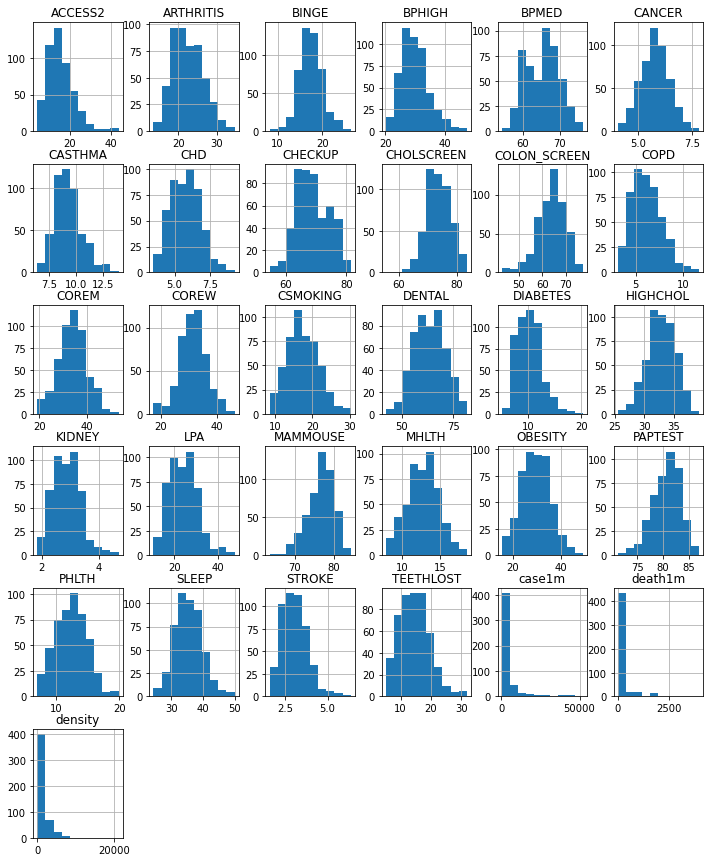

In [7]:
df.iloc[:,3:].hist(figsize = (12,15));

In [8]:
## Set X, y and split into train and test data set
X = df.drop(columns = ['county_fips','CityName','state_id','case1m', 'death1m','PAPTEST'])
y = df['death1m']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 42)

In [9]:
##Train the model using OLS
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est = est.fit()
print(est.summary().tables[0])

OLS Regression Results                            
Dep. Variable:                death1m   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     13.51
Date:                Tue, 14 Jul 2020   Prob (F-statistic):           3.40e-39
Time:                        23:14:49   Log-Likelihood:                -2520.5
No. Observations:                 347   AIC:                             5099.
Df Residuals:                     318   BIC:                             5211.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         


In [15]:
## Get significant variables
p = est.pvalues
significant_vars = p.loc[p < 0.10].index.tolist()

ols_coef = pd.read_html(est.summary().tables[1].as_html(),header=0,index_col=0)[0]
ols_coef.loc[ols_coef['P>|t|'] < 0.1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-3245.4204,1387.144,-2.340,0.020,-5974.559,-516.281
density,0.0683,0.016,4.172,0.000,0.036,0.100
ACCESS2,-20.1784,8.852,-2.280,0.023,-37.594,-2.763
ARTHRITIS,51.2526,21.464,2.388,0.018,9.023,93.482
CANCER,-285.3984,121.172,-2.355,0.019,-523.799,-46.997
CASTHMA,88.5298,36.961,2.395,0.017,15.810,161.249
CHECKUP,33.3058,11.344,2.936,0.004,10.988,55.624
COPD,-193.5914,76.614,-2.527,0.012,-344.326,-42.857
COREM,-19.5018,6.196,-3.147,0.002,-31.693,-7.311
DENTAL,23.6100,9.048,2.609,0.010,5.808,41.412


In [11]:
## Predict on test data
r2 = r2_score(y_test, est.predict(sm.add_constant(X_test)))
print('r2-score on test data: ', round(r2,4))

r2-score on test data:  0.2011


In [12]:
## Load measures lookup
lookup = pd.read_sql_table('MeasureLookup', engine)

In [13]:
## Get measures summary
categories = lookup.groupby('Category').agg({'MeasureId': 'count'})
categories

,MeasureId
Category,
Health Outcomes,13
Prevention,10
Unhealthy Behaviors,5


In [14]:
pd.set_option('display.max_colwidth', None)
lookup.loc[lookup['MeasureId'].isin(significant_vars)][['MeasureId','Measure', 'Category']].sort_values(by = 'Category')

,MeasureId,Measure,Category
2,HIGHCHOL,High cholesterol among adults aged >=18 Years who have been screened in the past 5 Years,Health Outcomes
7,ARTHRITIS,Arthritis among adults aged >=18 Years,Health Outcomes
8,CASTHMA,Current asthma among adults aged >=18 Years,Health Outcomes
9,DIABETES,Diagnosed diabetes among adults aged >=18 Years,Health Outcomes
17,CANCER,Cancer (excluding skin cancer) among adults aged >=18 Years,Health Outcomes
18,COPD,Chronic obstructive pulmonary disease among adults aged >=18 Years,Health Outcomes
10,ACCESS2,Current lack of health insurance among adults aged 18–64 Years,Prevention
21,DENTAL,Visits to dentist or dental clinic among adults aged >=18 Years,Prevention
23,CHECKUP,Visits to doctor for routine checkup within the past Year among adults aged >=18 Years,Prevention
27,COREM,"Older adult men aged >=65 Years who are up to date on a core set of clinical preventive services: Flu shot past Year, PPV shot ever, Colorectal cancer screening",Prevention
